In [1]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
from tqdm import tqdm

from kan_convolutional.KANConv import KAN_Convolutional_Layer

torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import splitfolders as sf
sf.ratio('data',ratio=(0.6,0.2,0.2),seed=42)

Copying files: 5631 files [00:00, 25135.48 files/s]


In [3]:
BATCH_SIZE = 1
EPOCHS = 5
LEARNING_RATE = 0.001

In [4]:
data_transformation = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [5]:
data_dir = './output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                           data_transformation[x])
                  for x in ['train', 'val', 'test']}
warnings.filterwarnings("ignore")
# Create DataLoader for training and validation datasets
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
# Get class names from the dataset
class_names = image_datasets['train'].classes
print(class_names, dataset_sizes)

['cloudy', 'desert', 'green_area', 'water'] {'train': 3378, 'val': 1126, 'test': 1127}


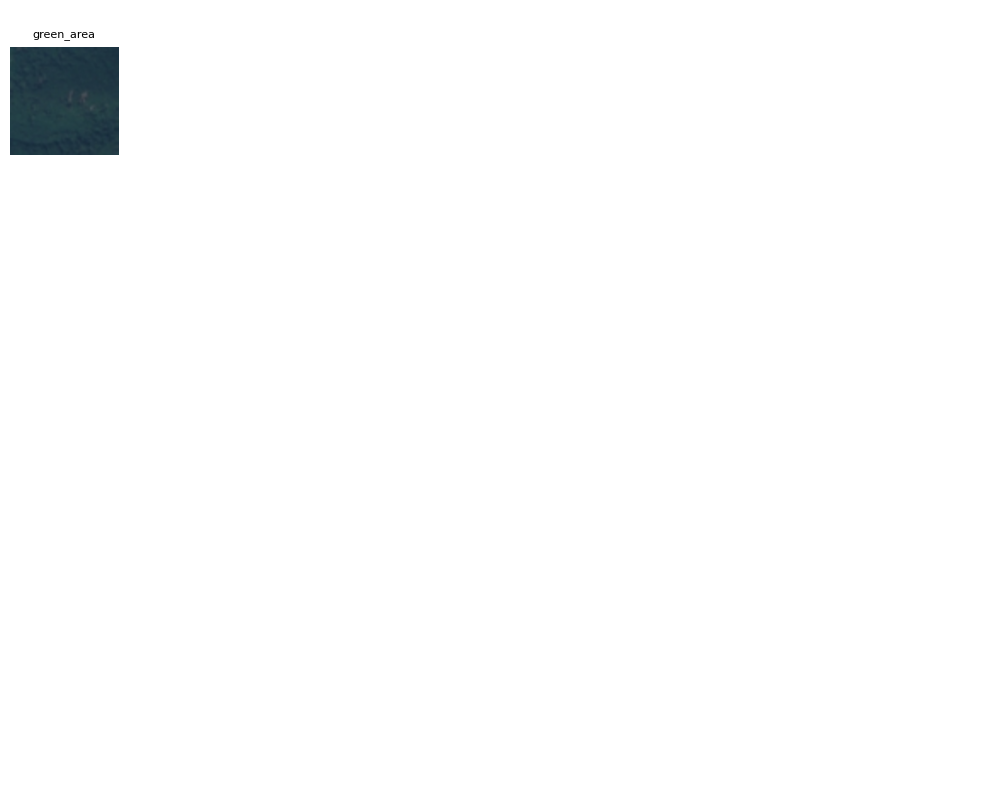

In [7]:
# visualize some images
# function to unnormalize and show an image
def imshow_single(img, ax, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(title, fontsize=8)
    ax.axis('off')

# get a batch of images
inputs, classes = next(iter(dataloaders['train']))

# set up the figure
fig, axes = plt.subplots(4, 8, figsize=(10, 8))  # 4 rows x 8 columns = 32 images
axes = axes.flatten()

# plot each image with its class name
for i in range(len(inputs)):
    imshow_single(inputs[i], axes[i], class_names[classes[i]])

# hide unused subplots if batch size < number of axes
for j in range(len(inputs), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # 128x128 → 128x128
        self.pool1 = nn.MaxPool2d(2, 2)                           # 128x128 → 64x64
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64x64 → 64x64
        self.pool2 = nn.MaxPool2d(2, 2)                           # 64x64 → 32x32
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # logits (no softmax here, CrossEntropyLoss expects logits)
        return x


In [9]:
class SimpleKANConv(nn.Module):
    def __init__(self, grid_size=5, num_classes=4):
        super(SimpleKANConv, self).__init__()

        self.conv1 = KAN_Convolutional_Layer(
            in_channels=3, out_channels=5, kernel_size=(3, 3), grid_size=grid_size
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 128x128 → 64x64

        self.conv2 = KAN_Convolutional_Layer(
            in_channels=5, out_channels=5, kernel_size=(3, 3), grid_size=grid_size
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 64x64 → 32x32

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(5 * 30 * 30, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # logits (no softmax)
        return x



========== Epoch 1/5 ==========


CNN Val: 100%|██████████| 1126/1126 [00:02<00:00, 553.30it/s]


CNN Val Loss: 0.5059 Acc: 0.7700
🕒 CNN Epoch time: 60.87 sec


KAN Val: 100%|██████████| 1126/1126 [00:50<00:00, 22.41it/s]


KAN Val Loss: 0.4444 Acc: 0.8446
🕒 KAN Epoch time: 286.39 sec

========== Epoch 2/5 ==========


CNN Val: 100%|██████████| 1126/1126 [00:02<00:00, 526.80it/s]


CNN Val Loss: 0.5881 Acc: 0.6758
🕒 CNN Epoch time: 61.40 sec


KAN Val: 100%|██████████| 1126/1126 [00:50<00:00, 22.33it/s]


KAN Val Loss: 0.2319 Acc: 0.9298
🕒 KAN Epoch time: 289.70 sec

========== Epoch 3/5 ==========


CNN Val: 100%|██████████| 1126/1126 [00:02<00:00, 479.19it/s]


CNN Val Loss: 0.6020 Acc: 0.6883
🕒 CNN Epoch time: 67.08 sec


KAN Val: 100%|██████████| 1126/1126 [00:50<00:00, 22.24it/s]


KAN Val Loss: 0.8495 Acc: 0.7798
🕒 KAN Epoch time: 298.96 sec

========== Epoch 4/5 ==========


CNN Val: 100%|██████████| 1126/1126 [00:02<00:00, 485.65it/s]


CNN Val Loss: 0.5902 Acc: 0.6767
🕒 CNN Epoch time: 67.11 sec


KAN Val: 100%|██████████| 1126/1126 [00:50<00:00, 22.12it/s]


KAN Val Loss: 0.3565 Acc: 0.8721
🕒 KAN Epoch time: 298.80 sec

========== Epoch 5/5 ==========


CNN Val: 100%|██████████| 1126/1126 [00:02<00:00, 470.19it/s]


CNN Val Loss: 0.4879 Acc: 0.7025
🕒 CNN Epoch time: 67.16 sec


KAN Val: 100%|██████████| 1126/1126 [00:50<00:00, 22.09it/s]


KAN Val Loss: 0.2444 Acc: 0.9218
🕒 KAN Epoch time: 299.21 sec


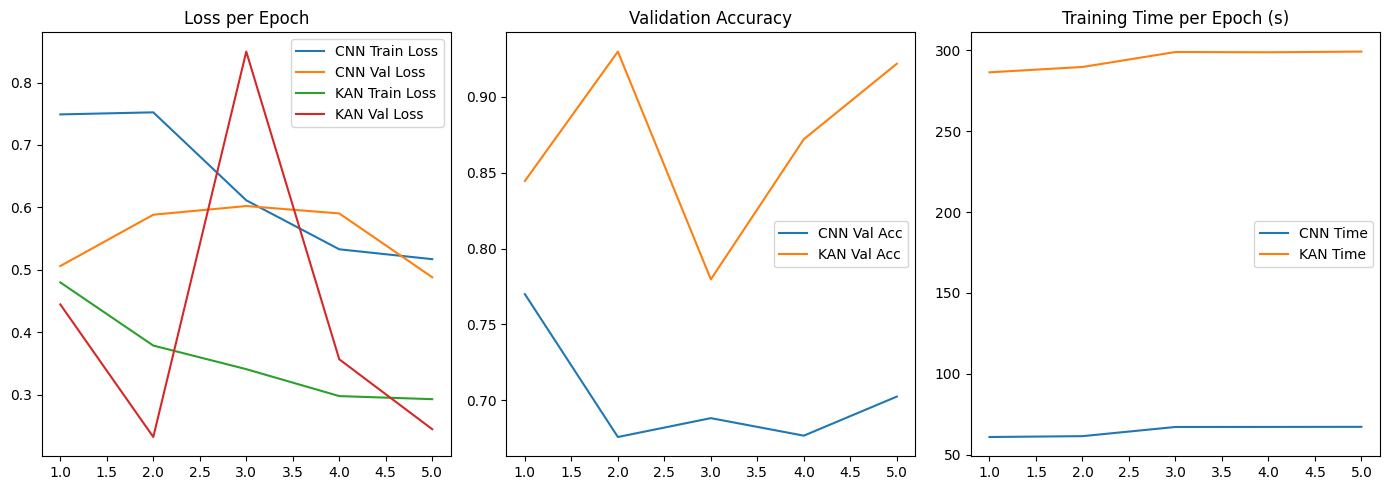


✅ Final Test Evaluation CNN:


CNN Test: 100%|██████████| 1127/1127 [00:02<00:00, 480.83it/s]


CNN Test Loss: 0.5015 Acc: 0.7019

✅ Final Test Evaluation KANConv:


KAN Test: 100%|██████████| 1127/1127 [00:51<00:00, 21.88it/s]

KAN Test Loss: 0.2214 Acc: 0.9237


(0.22142331084854533, 0.9236912156166814)

In [10]:
import time


# ------------------------------
# Define your two models here
# ------------------------------

cnn_model = SimpleCNN(num_classes=4).to(device)
kan_model = SimpleKANConv(grid_size=5, num_classes=4).to(device)

# ------------------------------
# Define Loss and Optimizer
# ------------------------------

criterion = nn.CrossEntropyLoss()

cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)
kan_optimizer = torch.optim.Adam(kan_model.parameters(), lr=LEARNING_RATE)

# ------------------------------
# Storage for metrics
# ------------------------------

cnn_train_loss = []
cnn_val_loss = []
cnn_val_acc = []
cnn_train_time = []

kan_train_loss = []
kan_val_loss = []
kan_val_acc = []
kan_train_time = []

# ------------------------------
# Function to evaluate model performance
# ------------------------------

def evaluate(model, dataloader, criterion, device, phase='val'):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"{phase}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, dim=1)
            targets = torch.argmax(labels, dim=1) if labels.ndim == 2 else labels

            running_loss += loss.item() * images.size(0)
            running_corrects += (preds == targets).sum().item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

# ------------------------------
# Load data 
# ------------------------------

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

# ------------------------------
# Training loop
# ------------------------------

for epoch in range(EPOCHS):
    print(f"\n========== Epoch {epoch+1}/{EPOCHS} ==========")
    
    # CNN ------------------------------------
    start_time = time.time()
    
    cnn_model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="CNN Train"):
        images, labels = images.to(device), labels.to(device)

        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        cnn_optimizer.zero_grad()
        loss.backward()
        cnn_optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    train_loss_epoch = running_loss / len(train_loader.dataset)
    cnn_train_loss.append(train_loss_epoch)
    
    # Validation
    val_loss, val_acc = evaluate(cnn_model, val_loader, criterion, device, phase='CNN Val')
    cnn_val_loss.append(val_loss)
    cnn_val_acc.append(val_acc)
    
    # Time
    epoch_time = time.time() - start_time
    cnn_train_time.append(epoch_time)
    print(f"🕒 CNN Epoch time: {epoch_time:.2f} sec")
    
    # KANConv ------------------------------------
    start_time = time.time()
    
    kan_model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="KAN Train"):
        images, labels = images.to(device), labels.to(device)

        outputs = kan_model(images)
        loss = criterion(outputs, labels)

        kan_optimizer.zero_grad()
        loss.backward()
        kan_optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    train_loss_epoch = running_loss / len(train_loader.dataset)
    kan_train_loss.append(train_loss_epoch)
    
    # Validation
    val_loss, val_acc = evaluate(kan_model, val_loader, criterion, device, phase='KAN Val')
    kan_val_loss.append(val_loss)
    kan_val_acc.append(val_acc)
    
    # Time
    epoch_time = time.time() - start_time
    kan_train_time.append(epoch_time)
    print(f"🕒 KAN Epoch time: {epoch_time:.2f} sec")

# ------------------------------
# Plot results (optional but recommended!)
# ------------------------------

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, cnn_train_loss, label='CNN Train Loss')
plt.plot(epochs_range, cnn_val_loss, label='CNN Val Loss')
plt.plot(epochs_range, kan_train_loss, label='KAN Train Loss')
plt.plot(epochs_range, kan_val_loss, label='KAN Val Loss')
plt.title('Loss per Epoch')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, cnn_val_acc, label='CNN Val Acc')
plt.plot(epochs_range, kan_val_acc, label='KAN Val Acc')
plt.title('Validation Accuracy')
plt.legend()

# Time
plt.subplot(1, 3, 3)
plt.plot(epochs_range, cnn_train_time, label='CNN Time')
plt.plot(epochs_range, kan_train_time, label='KAN Time')
plt.title('Training Time per Epoch (s)')
plt.legend()

plt.tight_layout()
plt.show()

# ------------------------------
# Final test accuracy (if you want)
# ------------------------------

print("\n✅ Final Test Evaluation CNN:")
evaluate(cnn_model, test_loader, criterion, device, phase='CNN Test')

print("\n✅ Final Test Evaluation KANConv:")
evaluate(kan_model, test_loader, criterion, device, phase='KAN Test')